In [1]:
from dask.distributed import Client
# see https://github.com/dask/distributed/issues/4168
import multiprocessing.popen_spawn_win32

client = Client(n_workers=4)

In [2]:
from preprocess import Preprocessor

import ml_inference
from ml_inference.automl import AutoRegressor
from ml_inference.baseline import BaselineRegressor
from ml_inference.test import cv_test, gen_score_plot
from ml_inference.inference import explain_performance, explain_predictions, explain_correlations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline

import random

np.random.seed(0)
random.seed(0)

pd.options.mode.chained_assignment = None
INFILE = '../data/pennycook_et_al_study2_clean.csv'

In [3]:
df = pd.read_csv(INFILE)
df = df[df.Treatment == 0].drop(columns='Treatment').reset_index(drop=True)
X, y = df.drop(columns='Diff'), df.Diff
y = (y - y.mean()) / y.std()
df.head()

,SharingType_1,SharingType_2,SharingType_3,SharingType_4,SharingType_6,SharingType_5,SocialMedia_1,SocialMedia_2,SocialMedia_3,SocialMedia_4,...,Male,Education,Income,English,Partisan,Social_Conserv,Economic_Conserv,Diff,Party,POTUS2016
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,19.0,3.0,1.0,5.0,4.0,4.0,-0.666667,Republican,Trump
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,16.0,7.0,1.0,3.0,2.0,2.0,0.000000,Independent,Clinton
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,13.0,4.0,1.0,2.0,4.0,4.0,0.000000,Democrat,Clinton
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,14.0,6.0,1.0,1.0,5.0,5.0,0.200000,Democrat,Clinton
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,15.0,3.0,1.0,3.0,3.0,3.0,-0.200000,Democrat,Other


In [4]:
%%time

baseline_reg = BaselineRegressor()

linear_reg = make_pipeline(
    Preprocessor(),
    LinearRegression()
)

ml_reg = AutoRegressor(preprocessors=Preprocessor(), n_jobs=-1).fit(X, y).best_estimator_

estimators = [
    ('Baseline', baseline_reg), 
    ('Linear', linear_reg), 
    ('Machine learning', ml_reg)
]


Tuning estimator 1 of 18: RandomForestRegressorCV
Best estimator score: 0.1370

Tuning estimator 2 of 18: PCARandomForestRegressorCV
Best estimator score: 0.0312

Tuning estimator 3 of 18: LassoLarsCV
Best estimator score: -0.0121

Tuning estimator 4 of 18: PCALassoLarsCV
Best estimator score: -0.0121

Tuning estimator 5 of 18: RidgeCV
Best estimator score: 0.1024

Tuning estimator 6 of 18: PCARidgeCV
Best estimator score: 0.0847

Tuning estimator 7 of 18: ElasticNetCV
Best estimator score: -0.0121

Tuning estimator 8 of 18: PCAElasticNetCV
Best estimator score: -0.0121

Tuning estimator 9 of 18: KernelRidgeCV
Best estimator score: 0.1359

Tuning estimator 10 of 18: PCAKernelRidgeCV
Best estimator score: 0.1015

Tuning estimator 11 of 18: SVRCV
Best estimator score: 0.1085

Tuning estimator 12 of 18: PCASVRCV
Best estimator score: 0.0922

Tuning estimator 13 of 18: KNeighborsRegressorCV
Best estimator score: 0.0891

Tuning estimator 14 of 18: PCAKNeighborsRegressorCV
Best estimator sc

Wall time: 43.1 s


,Model1,Model2,MeanDifference,t-stat,p-value
0,Baseline,Linear,-0.162393,-11.397176,1.192939e-06
1,Baseline,Machine learning,0.099821,20.792302,6.443708e-09
2,Linear,Machine learning,0.262215,17.926266,2.378912e-08


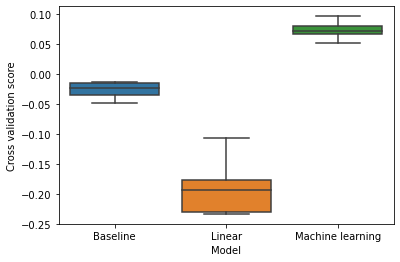

In [5]:
%%time

from sklearn.metrics import r2_score

scores, pairwise_tests = cv_test(estimators, X, y, scorer=r2_score, parallel=True)
ax = gen_score_plot(scores, showfliers=False)
pairwise_tests

In [ ]:
from sklearn.metrics import r2_score
    
def prefix_group(prefix):
    return [col for col in X.columns if col.startswith(prefix)]
    
perf_groups = [
    ('Sharing content', prefix_group('SharingType')),
    ('Social media use', prefix_group('SocialMedia')),
    ('CRT', prefix_group('CRT')),
    ('Scientific knowledge', prefix_group('sci')),
    ('Medical maximizing', prefix_group('mms')),
    ('News media', prefix_group('Media')),
    ('Ethnicity', prefix_group('Ethnicity')),
    ('Politics', ['Partisan', 'Social_Conserv', 'Economic_Conserv', 'Party', 'POTUS2016'])
]
ml_reg.fit(X, y)
df, ax = explain_performance(ml_reg.predict, X, y, metric=r2_score, nsamples=2**5, groups=perf_groups)
ax.set(xlabel='Amount of explained variance')
df

In [ ]:
predict_groups = [
    ('Sharing content', prefix_group('SharingType')),
    ('Social media use', prefix_group('SocialMedia')),
    ('CRT', prefix_group('CRT')),
    ('Scientific knowledge', prefix_group('sci')),
    ('Medical maximizing', prefix_group('mms')),
    ('Ethnicity', prefix_group('Ethnicity')),
]
df = explain_predictions(ml_reg.predict, X, y, nsamples=2**5, groups=predict_groups)

In [ ]:
mms = X[[col for col in X.columns if col.startswith('mms')]].sum(axis=1)
ax = sns.scatterplot(x=mms, y=df['Medical maximizing'])
# indicates that some MMS questions are much more diagnostic of sharing discernment than others
ax.set(xlabel='Medical maximizing score', ylabel='Effect on prediction')

In [ ]:
media_values = list(range(1, 6))
media_vars = [
    ('Media3_1', 'national news'),
    ('Media3_2', 'local news'),
    ('Media3_12', 'fact checkers'),
    ('Media3_3', 'friends and family for news'),
    ('Media3_11', 'social media for news')
]
for var, label in media_vars:
    mask = X[var].isin(media_values)
    ax = sns.boxplot(x=X[var][mask], y=df[var][mask], showfliers=False)
    ax.set(xlabel='Trust in '+label, ylabel='Effect on prediction', ylim=(-.15, .15))
    plt.show()

In [ ]:
X_preproc = Preprocessor(X).transform(X)
cols = [col for col in X_preproc.columns if col.startswith('CRT') and col.endswith('intuit')]
crt = X_preproc[cols].sum(axis=1)
ax = sns.violinplot(x=crt, y=df.CRT)
ax.set(xlabel='CRT intuitive responses', ylabel='Effect of CRT on prediction')

In [ ]:
candidates = ['Trump', 'Other', 'Clinton']
mask = X.POTUS2016.isin(candidates)
ax = sns.boxplot(x=X.POTUS2016[mask], y=df.POTUS2016[mask], showfliers=False, order=candidates)
ax.set(xlabel='Voted for in 2016', ylabel='Effect on prediction')

In [ ]:
mask = X.Party.isin(['Republican', 'Democrat', 'Independent'])
ax = sns.boxplot(x=X.Party[mask], y=df.Party[mask], showfliers=False)
ax.set(xlabel='Political party', ylabel='Effect on prediction')

In [ ]:
partisan_vals = list(range(1, 7))
mask = X.Partisan.isin(partisan_vals)
ax = sns.boxplot(x=X.Partisan[mask], y=df.Partisan[mask], showfliers=False)
ax.set(xlabel='<= Democrat, Republican =>', ylabel='Effect on prediction')

In [ ]:
sci = X[[col for col in X.columns if col.startswith('sci')]].sum(axis=1)
ax = sns.scatterplot(x=sci, y=df['Scientific knowledge'])
ax.set(xlabel='Scientific knowledge', ylabel='Effect on prediction')

In [ ]:
ax = sns.scatterplot(x=X.COVID_concern, y=df['COVID_concern'])
ax.set(xlabel='Concern about COVID-19', ylabel='Effect on prediction')

In [ ]:
ax = sns.scatterplot(x=X.Age, y=df.Age)
ax.set(ylabel='Effect on prediction')

In [ ]:
ax = sns.boxplot(x=X.COVID_news, y=df.COVID_news, showfliers=False)
ax.set(xlabel='How often you check COVID-19 news', ylabel='Effect on prediction')

In [ ]:
mask = X.Education.isin(list(range(21)))
ax = sns.boxplot(x=X[mask].Education, y=df[mask].Education, showfliers=False)
ax.set(xlabel='Years of education', ylabel='Effect on prediction')
ax.set_xticks(list(range(0, 21, 4)))

In [ ]:
features = ['COVID_concern', 'COVID_news', 'Education', 'Income']
corr_df, plots = explain_correlations(features, ml_reg.predict, X, y, groups=perf_groups, nsamples=2**5)
corr_df

In [ ]:
X_preproc['Scientific knowledge'] = sci
X_preproc['MMS'] = mms
X_preproc['Diff'] = y
X_preproc[['Education', 'Scientific knowledge', 'Media3_1', 'Media3_3', 'Media3_11', 'Income', 'Party_Democrat', 'MMS', 'Diff']].corr()